# Análise de Superlotação em Hospitais da Paraíba – Hospitais da Paraíba (Jan–Nov 2024)
Por: Cecília Paiva

### Hospital e Leito
Fonte: OpenDataSUS

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

hospital_e_leitos_br = pd.read_csv("dados/Leitos_2024.csv", encoding='ISO-8859-1')

# Limpeza de dados
hospital_e_leitos_pb = hospital_e_leitos_br[(hospital_e_leitos_br['UF'] == 'PB')]

hospital_e_leitos_pb = hospital_e_leitos_pb.drop(['REGIAO', 'UF', 'MOTIVO_DESABILITACAO', 'CO_TIPO_UNIDADE', 'NATUREZA_JURIDICA', 'NO_COMPLEMENTO'], axis=1)

hospital_e_leitos_pb[['NU_TELEFONE', 'NO_EMAIL']] = hospital_e_leitos_pb[['NU_TELEFONE', 'NO_EMAIL']].fillna('Não se aplica')

hospital_e_leitos_pb = hospital_e_leitos_pb.rename(columns={
    'COMP':'ANO_MES_COMPETENCIA',
    'CNES':'ID_CNES',
    'TP_GESTAO':'TIPO_GESTAO'
})

hospital_e_leitos_pb['TIPO_GESTAO'] = hospital_e_leitos_pb['TIPO_GESTAO'].replace({
    'M':'Municipal',
    'E':'Estadual',
    'D':'Dupla',
    'S':'Sem Gestão'
})

### SIH João Pessoa
Fonte: PySUS

In [3]:
# Dicionário de Variáveis (https://pcdas.icict.fiocruz.br/conjunto-de-dados/sistema-de-informacoes-hospitalares-do-sus-sihsus/dicionario-de-variaveis/)
sih_pb_2024 = pd.read_csv('dados/dados_sih_pb_2024.csv')

# Limpeza de dados
sih_pb_2024 = sih_pb_2024.drop(['UF_ZI', 'CGC_HOSP', 'N_AIH', 'IDENT', 'CEP', 'MUNIC_RES', 'NASC', 'SEXO',
                                'UTI_MES_IN', 'UTI_MES_AN', 'UTI_MES_AL', 'UTI_MES_TO','UTI_INT_IN', 
                                'UTI_INT_AN', 'UTI_INT_AL', 'UTI_INT_TO', 'DIAR_ACOM', 'QT_DIARIAS',
                                'PROC_SOLIC', 'VAL_SH', 'VAL_SP', 'VAL_SADT', 'VAL_RN', 'VAL_ACOMP',
                                'VAL_ORTP', 'VAL_SANGUE', 'VAL_SADTSR', 'VAL_TRANSP', 'VAL_OBSANG',
                                'VAL_PED1AC', 'VAL_UTI', 'US_TOT', 'DIAG_SECUN','COBRANCA', 'NATUREZA',
                                'NAT_JUR', 'GESTAO', 'RUBRICA', 'IND_VDRL', 'COD_IDADE', 'NACIONAL', 'NUM_PROC',
                                'CAR_INT', 'TOT_PT_SP', 'INSTRU', 'CID_NOTIF', 'CONTRACEP1', 'CONTRACEP2', 'GESTRISCO',
                                'INSC_PN', 'GESTOR_COD', 'GESTOR_TP', 'GESTOR_CPF', 'GESTOR_DT', 'CNPJ_MANT', 'INFEHOSP', 'CID_ASSO',
                                'CID_MORTE', 'COMPLEX', 'FINANC', 'FAEC_TP', 'REGCT', 'AUD_JUST', 'SIS_JUST', 'VAL_SH_FED', 'DIAGSEC6',
                                'DIAGSEC7', 'DIAGSEC8', 'DIAGSEC9', 'TPDISEC1', 'TPDISEC4', 'TPDISEC5', 'TPDISEC6', 'TPDISEC7', 'TPDISEC8', 'TPDISEC9', 
                                'CBOR', 'CNAER', 'VINCPREV', 'CPF_AUT', 'HOMONIMO', 'NUM_FILHOS', 'SEQ_AIH5', 'RACA_COR', 'ETNIA', 'SEQUENCIA', 'REMESSA',
                                'VAL_SP_FED', 'VAL_SH_GES', 'VAL_SP_GES', 'VAL_UCI', 'MARCA_UCI', 'DIAGSEC1', 'DIAGSEC2', 'DIAGSEC3', 'DIAGSEC4', 'DIAGSEC5',
                                'TPDISEC2', 'TPDISEC3', 'MARCA_UTI'], axis=1)

sih_pb_2024 = sih_pb_2024.rename(columns={
    'ESPEC': 'especialidade_leito',
    'PROC_REA': 'procedimento_realizado',
    'VAL_TOT': 'valor_total_aih',
    'DT_INTER': 'dt_internacao',
    'DT_SAIDA': 'dt_saida',
    'DIAG_PRINC': 'cid_principal',
    'MUNIC_MOV': 'municipio_estabelecimento',
    'DIAS_PERM': 'dias_permanencia',
    'MORTE': 'obito',
    'CNES': 'id_cnes',
})

sih_pb_2024 = sih_pb_2024[sih_pb_2024['MES_CMPT'] <= 11]

/tmp/ipykernel_800/512246821.py:2: DtypeWarning: Columns (97,98,99,100,101,102) have mixed types. Specify dtype option on import or set low_memory=False.
  sih_pb_2024 = pd.read_csv('dados/dados_sih_pb_2024.csv')


### Percentual de Ocupacão Diária dos Leitos
Os dados são de janeiro a novembro de 2024

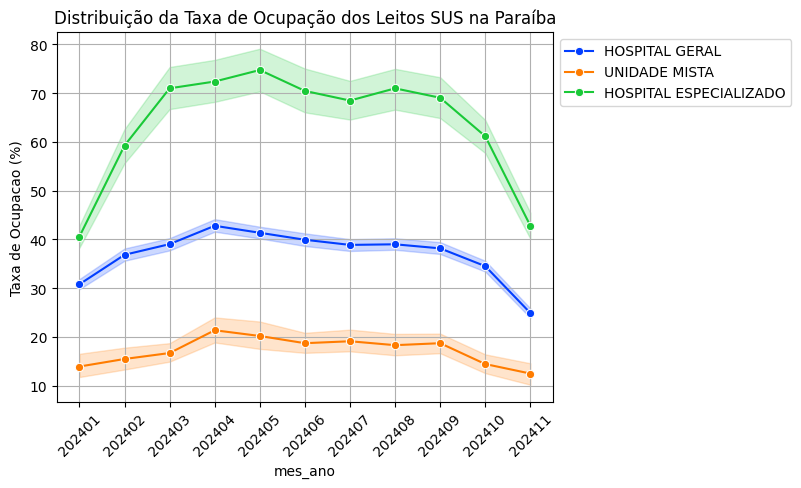

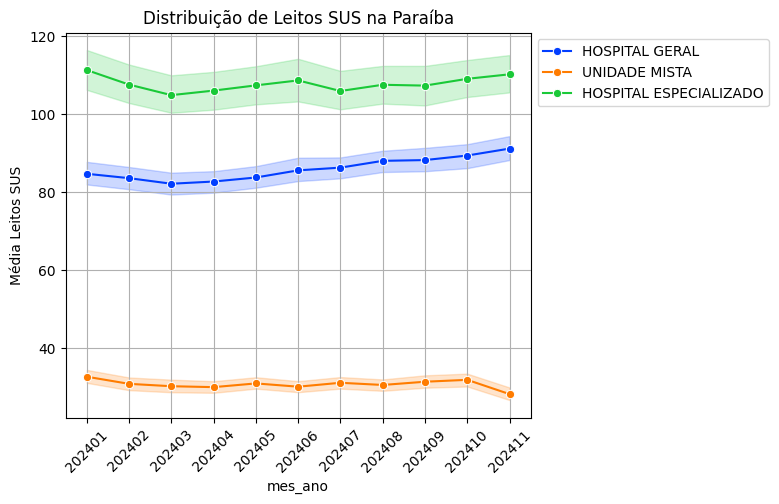

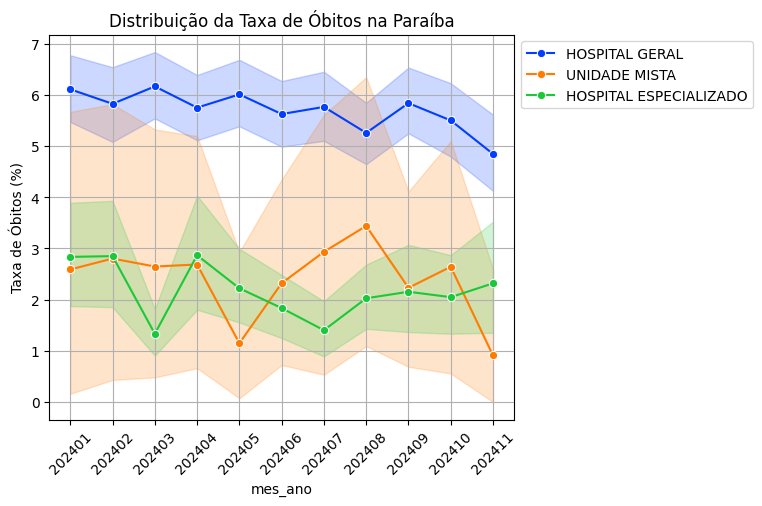

In [4]:
# pegando apenas o ano e mes e inserindo em nova coluna
sih_pb_2024['mes_ano'] = sih_pb_2024['dt_internacao'].astype(str).str[:6]
sih_pb_2024['mes_ano_saida'] = sih_pb_2024['dt_saida'].astype(str).str[:6]
sih_pb_2024 = sih_pb_2024[sih_pb_2024['mes_ano'] >= '202401'] # pega apenas o ano de 2024
hospital_e_leitos_pb['mes_ano_leitos'] = hospital_e_leitos_pb['ANO_MES_COMPETENCIA'].astype(str)

# pegando as quantidade de entrada, saidas e leitos por hospital e mês
qtd_entradas = sih_pb_2024.groupby(['id_cnes', 'mes_ano', 'dt_internacao']).size().reset_index(name='qtd_entradas')
qtd_saidas = sih_pb_2024.groupby(['id_cnes', 'mes_ano_saida', 'dt_saida']).size().reset_index(name='qtd_saidas')
qtd_saidas = qtd_saidas.rename(columns={'mes_ano_saida': 'mes_ano', 'dt_saida': 'data'})
qtd_entradas = qtd_entradas.rename(columns={'dt_internacao': 'data'})
qtd_leitos_sus = hospital_e_leitos_pb[['ID_CNES', 'mes_ano_leitos', 'LEITOS_SUS']]
sih_pb_2024['data'] = sih_pb_2024['dt_internacao']
taxa_obitos_pct = sih_pb_2024.groupby(['id_cnes', 'mes_ano', 'data'])['obito'].mean().mul(100).round(2).reset_index(name='taxa_obito_pct')

# juntando e limpando o novo df
df_ocupacao_diaria = pd.merge(qtd_entradas, qtd_saidas, on=['id_cnes', 'mes_ano', 'data'], how='outer')
df_ocupacao_diaria = pd.merge(df_ocupacao_diaria, hospital_e_leitos_pb[['ID_CNES', 'mes_ano_leitos', 'LEITOS_SUS', 'DS_TIPO_UNIDADE', 'MUNICIPIO']], left_on=['id_cnes', 'mes_ano'], right_on=['ID_CNES', 'mes_ano_leitos'], how='left')
df_ocupacao_diaria = pd.merge(df_ocupacao_diaria, taxa_obitos_pct, on=['id_cnes', 'mes_ano', 'data'], how='left')

df_ocupacao_diaria = df_ocupacao_diaria.drop(['mes_ano_leitos', 'ID_CNES'], axis=1)
df_ocupacao_diaria = df_ocupacao_diaria.rename(columns={'LEITOS_SUS': 'total_leitos_sus'})
df_ocupacao_diaria = df_ocupacao_diaria[df_ocupacao_diaria['total_leitos_sus'].notna()]
df_ocupacao_diaria['qtd_entradas'] = df_ocupacao_diaria['qtd_entradas'].fillna(0).astype(int)
df_ocupacao_diaria['qtd_saidas'] = df_ocupacao_diaria['qtd_saidas'].fillna(0).astype(int)
df_ocupacao_diaria['total_leitos_sus'] = df_ocupacao_diaria['total_leitos_sus'].astype(int)
df_ocupacao_diaria['taxa_obito_pct'] = df_ocupacao_diaria['taxa_obito_pct'].fillna(0)

df_ocupacao_diaria['dif_entrada_saida'] = df_ocupacao_diaria['qtd_entradas'] - df_ocupacao_diaria['qtd_saidas']
df_ocupacao_diaria['leitos_ocupados'] = df_ocupacao_diaria.groupby(['id_cnes'])['dif_entrada_saida'].cumsum() 

# Calculando a taxa de ocupação diária
df_ocupacao_diaria['taxa_ocupacao_diaria_pct'] = (df_ocupacao_diaria['leitos_ocupados'] / df_ocupacao_diaria['total_leitos_sus']) * 100
df_ocupacao_diaria['taxa_ocupacao_diaria_pct'] = df_ocupacao_diaria['taxa_ocupacao_diaria_pct'].round(2)


plt.title('Distribuição da Taxa de Ocupação dos Leitos SUS na Paraíba')
plt.ylabel('Taxa de Ocupacao (%)')
plt.grid(True)
plt.xticks(rotation=45)
sns.lineplot(data=df_ocupacao_diaria, x="mes_ano", y="taxa_ocupacao_diaria_pct", hue="DS_TIPO_UNIDADE", palette="bright", marker="o")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.subplots(figsize=(6, 5))
plt.title('Distribuição de Leitos SUS na Paraíba')
plt.ylabel('Média Leitos SUS')
plt.grid(True)
plt.xticks(rotation=45)
sns.lineplot(data=df_ocupacao_diaria, x="mes_ano", y="total_leitos_sus", hue="DS_TIPO_UNIDADE", palette="bright", marker="o")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.subplots(figsize=(6, 5))
plt.title('Distribuição da Taxa de Óbitos na Paraíba')
plt.ylabel('Taxa de Óbitos (%)')
plt.grid(True)
plt.xticks(rotation=45)
sns.lineplot(data=df_ocupacao_diaria, x="mes_ano", y="taxa_obito_pct", hue="DS_TIPO_UNIDADE", palette="bright", marker="o")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

### Média de Ocupacão Hospitalar

<Axes: title={'center': 'Distribuição da Ocupação Média Diária'}, xlabel='Média de Ocupação Diária', ylabel='Count'>

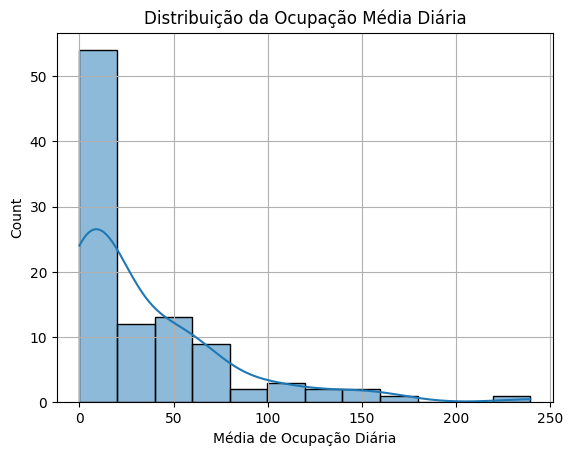

In [5]:
entrada_stats = df_ocupacao_diaria.groupby(['id_cnes'])['qtd_entradas'].mean(numeric_only=True).round(2)
permanencia_stats = sih_pb_2024.groupby(['id_cnes'])['dias_permanencia'].mean().round(2)
leitos_sus_mean = df_ocupacao_diaria.groupby(['id_cnes'])['total_leitos_sus'].mean().round(2)
obitos_mean = sih_pb_2024.groupby(['id_cnes'])['obito'].mean().mul(100).round(0)
taxa_ocupacao_mean_pct = df_ocupacao_diaria.groupby(['id_cnes'])['taxa_ocupacao_diaria_pct'].mean().round(2)

df_stats = pd.DataFrame({
    'qtd_entradas_mean': entrada_stats,
    'dias_permanencia_mean': permanencia_stats,
    'leitos_sus_mean': leitos_sus_mean,
    'obitos_mean': obitos_mean,
    'taxa_ocupacao_mean_pct': taxa_ocupacao_mean_pct
    })

df_stats = df_stats.dropna(subset=['leitos_sus_mean'])
# Em leitos_sus_mean está faltando 5 hospitais que estão registrados em sih_pb_2024, mas não estão em hospital_e_leitos_pb
# Porém, esses hospitais tiveram a ocupacão média diária igual a 0, devido a baixa quantidade de entradas e nenhum dia de permanêcia

df_stats['qtd_entradas_mean'] = df_stats['qtd_entradas_mean'].fillna(0)
df_stats['dias_permanencia_mean'] = df_stats['dias_permanencia_mean'].fillna(0)

# ocupacao_media_diaria = entrada_media * dias_permanencia_media
df_stats['ocupacao_media_diaria'] = df_stats['qtd_entradas_mean'] * df_stats['dias_permanencia_mean']
df_stats['ocupacao_media_diaria'] = df_stats['ocupacao_media_diaria'].round(2)

hospital_e_leitos_pb['ID_CNES'] = hospital_e_leitos_pb['ID_CNES'].astype(int)
df_stats['tipo_unidade'] = hospital_e_leitos_pb.groupby(['ID_CNES'])['DS_TIPO_UNIDADE'].first()
df_stats['nome_hospital'] = hospital_e_leitos_pb.groupby(['ID_CNES'])['NOME_ESTABELECIMENTO'].first()
df_stats['municipio'] = hospital_e_leitos_pb.groupby(['ID_CNES'])['MUNICIPIO'].first()

# distribuição geral da média de ocupação em 2024
plt.title('Distribuição da Ocupação Média Diária')
plt.xlabel('Média de Ocupação Diária')
plt.grid(True)
sns.histplot(data=df_stats, x='ocupacao_media_diaria', kde=True)

### Média de Ocupação Hospitalar
Vamos entender a demanda dos hospitais localizados no Estado da Paraíba.

<Axes: title={'center': 'Tipos de Unidade com SUS na Paraíba'}, xlabel='DS_TIPO_UNIDADE', ylabel='Quantidade de Unidades'>

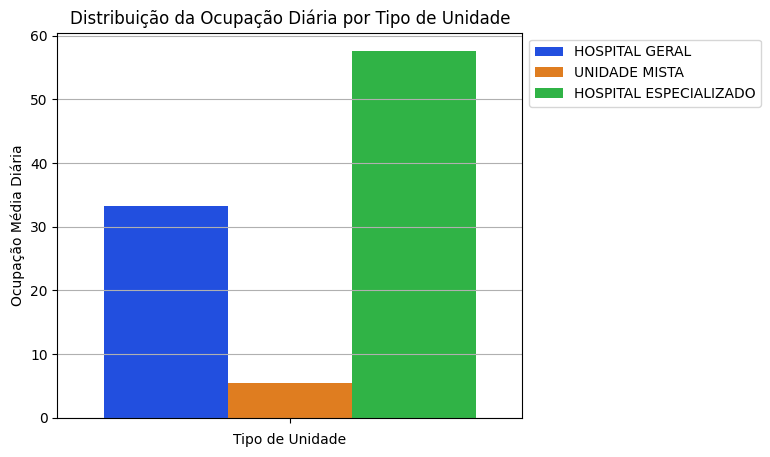

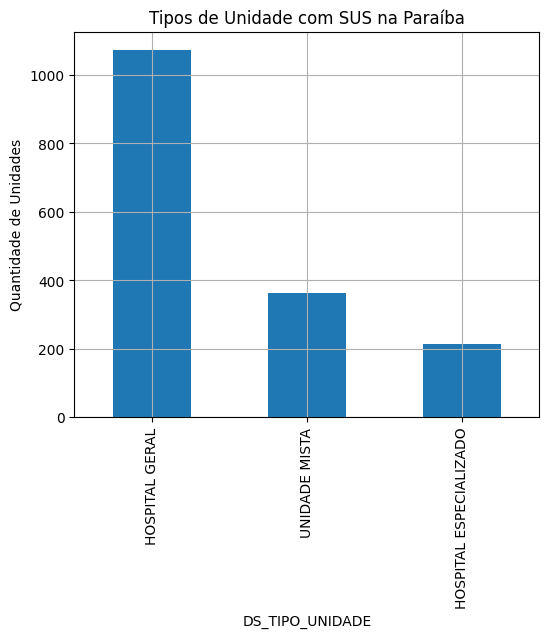

In [6]:
plt.subplots(figsize=(6, 5))
plt.title('Distribuição da Ocupação Diária por Tipo de Unidade')
plt.ylabel('Ocupação Média Diária')
plt.xlabel('Tipo de Unidade')
plt.grid(True)
sns.barplot(data=df_stats, y='ocupacao_media_diaria', hue='tipo_unidade', errorbar=None, palette='bright')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# quantificar os tipos de unidades na Paraíba
plt.subplots(figsize=(6, 5))
plt.title('Tipos de Unidade com SUS na Paraíba')
plt.ylabel('Quantidade de Unidades')
plt.xlabel('Tipo de Unidade')
tipos_unidades_sus = hospital_e_leitos_pb[hospital_e_leitos_pb['LEITOS_SUS'] > 0]
tipos_unidades_sus['DS_TIPO_UNIDADE'].value_counts().plot(kind='bar', grid=True)

==========(ocupacao_media_diaria)==========
Média: 34.99 / Mediana: 13.40 / Moda: 2.22
None
IQR: 47.61
Limite Inferior: -66.58
Limite Superior: 123.84
------------Outliers------------
              municipio  ocupacao_media_diaria            tipo_unidade
id_cnes                                                               
2362856  CAMPINA GRANDE                 239.35          HOSPITAL GERAL
2399628     JOAO PESSOA                 154.65          HOSPITAL GERAL
2400324     JOAO PESSOA                 150.85          HOSPITAL GERAL
2593262     JOAO PESSOA                 136.10          HOSPITAL GERAL
2613735  CAMPINA GRANDE                 128.94  HOSPITAL ESPECIALIZADO
9467718      SANTA RITA                 167.16          HOSPITAL GERAL
------------Resumo------------
count     99.00
mean      34.99
std       44.07
min        0.00
25%        4.83
50%       13.40
75%       52.44
max      239.35
Name: ocupacao_media_diaria, dtype: float64
------------Top 6 Hospitais Mais Ocupados----

,nome_hospital,municipio,ocupacao_media_diaria
id_cnes,,,
2362856,HOSPITAL EMERGENCIA E TRAUMA DOM LUIZ GONZAGA ...,CAMPINA GRANDE,239.35
9467718,HOSPITAL METROPOLITANO DOM JOSE MARIA PIRES,SANTA RITA,167.16
2399628,COMPLEXO HOSPITALAR DE MANGABEIRA GOV TARCISIO...,JOAO PESSOA,154.65
2400324,HOSPITAL EDSON RAMALHO,JOAO PESSOA,150.85
2593262,HOSPITAL DE EMERGENCIA E TRAUMA SENADOR HUMBER...,JOAO PESSOA,136.10
2613735,CLINICA DR MAIA,CAMPINA GRANDE,128.94


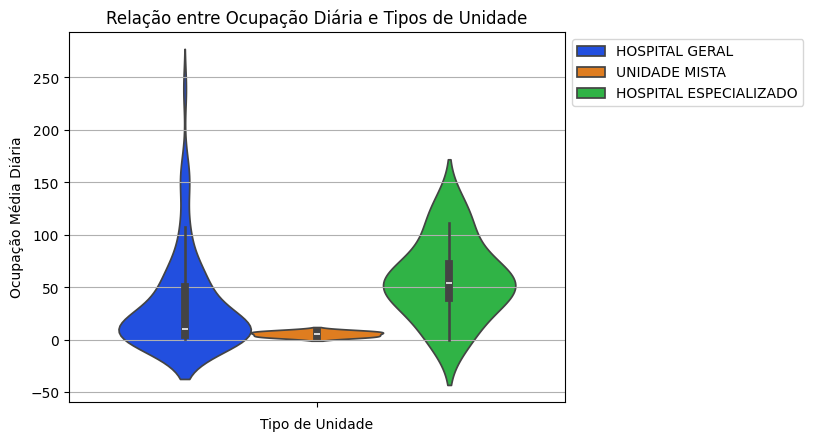

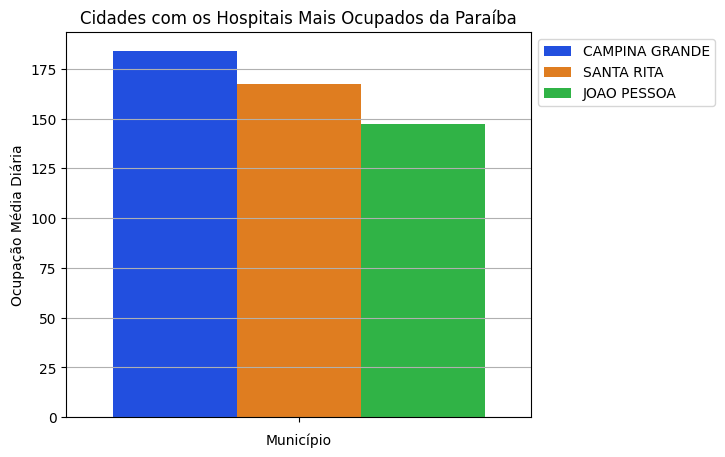

In [7]:
plt.title('Relação entre Ocupação Diária e Tipos de Unidade')
plt.ylabel('Ocupação Média Diária')
plt.xlabel('Tipo de Unidade')
plt.grid(True)
sns.violinplot(data=df_stats, hue='tipo_unidade', y='ocupacao_media_diaria', palette='bright')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# top 6 hospitais mais ocupados
top_6_hospitais = df_stats.nlargest(6, 'ocupacao_media_diaria')
plt.subplots(figsize=(6, 5))
plt.title('Cidades com os Hospitais Mais Ocupados da Paraíba')
plt.ylabel('Ocupação Média Diária')
plt.xlabel('Município')
plt.grid(True)  
sns.barplot(data=top_6_hospitais, hue='municipio', y='ocupacao_media_diaria', errorbar=None, palette='bright')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# medidas de centralidade
def medidas_centralidade(df, coluna):
    media = df[coluna].mean()
    mediana = df[coluna].median()
    moda = df[coluna].mode()[0]
    print(f"==========({coluna})==========\nMédia: {media:.2f} / Mediana: {mediana:.2f} / Moda: {moda:.2f}")

print(medidas_centralidade(df_stats, 'ocupacao_media_diaria'))

# medidas de variabilidade
def medidas_variabilidade(df, coluna):
    q1 = df[coluna].quantile(0.25)
    q3 = df[coluna].quantile(0.75)
    IQR = q3 - q1
    lim_inferior = q1 - 1.5 * IQR
    lim_superior = q3 + 1.5 * IQR
    print(f"IQR: {IQR:.2f}")
    print(f"Limite Inferior: {lim_inferior:.2f}")
    print(f"Limite Superior: {lim_superior:.2f}")
    outliers = df[(df[coluna] < lim_inferior) | (df[coluna] > lim_superior)]
    print(f"------------Outliers------------\n{outliers[['municipio', coluna, 'tipo_unidade']]}")
    print(f"------------Resumo------------\n{df[coluna].describe().round(2)}")

medidas_variabilidade(df_stats, 'ocupacao_media_diaria')
print(f"------------Top 6 Hospitais Mais Ocupados------------")
top_6_hospitais[['nome_hospital', 'municipio', 'ocupacao_media_diaria']].sort_values(by='ocupacao_media_diaria', ascending=False)

No contexto do Estado da Paraíba, as maiores médias de ocupação diária se encontra em unidades do tipo: hospital geral e hospital especializado (Hospitais que possuem leitos do SUS). Sendo os hospitais especializados os mais afetados, porém, são os que tem menos distribuição no Estado. Foi encontrado 6 dados extremos, provenientes de hospitais localizados em regiões metropolitanas da Paraíba, e esses outliers são os top 6 hospitais com as maiores médias de ocupação diária em 2024.

### Quais as CIDs principais mais frequentes nos 10 hospitais mais ocupados?

,id_cnes,cid_principal,qtd_cids_frequentes,nome_hospital,municipio,DS_TIPO_UNIDADE
0,2362856,Apendicite aguda,874,HOSPITAL EMERGENCIA E TRAUMA DOM LUIZ GONZAGA ...,CAMPINA GRANDE,HOSPITAL GERAL
11,2399628,Fratura da extremidade distal do rádio,731,COMPLEXO HOSPITALAR DE MANGABEIRA GOV TARCISIO...,JOAO PESSOA,HOSPITAL GERAL
22,2399644,Esterilização,978,MATERNIDADE CANDIDA VARGAS,JOAO PESSOA,HOSPITAL ESPECIALIZADO
33,2400243,Parto espontâneo cefálico,320,HOSPITAL UNIVERSITARIO LAURO WANDERLEY,JOAO PESSOA,HOSPITAL GERAL
44,2400324,Parto espontâneo cefálico,819,HOSPITAL EDSON RAMALHO,JOAO PESSOA,HOSPITAL GERAL
55,2593262,Acidente vascular cerebral,756,HOSPITAL DE EMERGENCIA E TRAUMA SENADOR HUMBER...,JOAO PESSOA,HOSPITAL GERAL
66,2605473,Infarto agudo do miocárdio,501,COMPLEXO HOSPITALAR DEP JANDUHY CARNEIRO,PATOS,HOSPITAL GERAL
77,2613476,Parto por cesariana,693,HOSPITAL REGIONAL DE CAJAZEIRAS,CAJAZEIRAS,HOSPITAL GERAL
88,2613735,Síndrome de dependência,331,CLINICA DR MAIA,CAMPINA GRANDE,HOSPITAL ESPECIALIZADO
99,9467718,Infarto agudo do miocárdio,389,HOSPITAL METROPOLITANO DOM JOSE MARIA PIRES,SANTA RITA,HOSPITAL GERAL


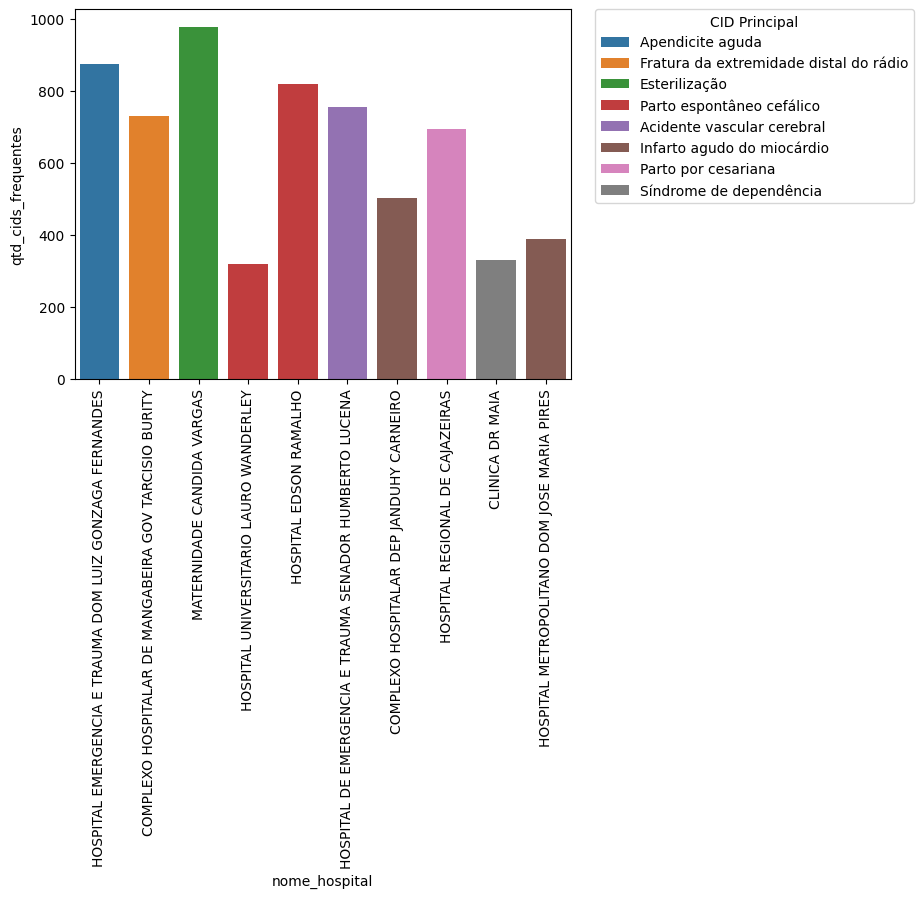

In [8]:
top_10_ocupacao = df_stats.nlargest(10, 'ocupacao_media_diaria')
cids_frequentes = sih_pb_2024[sih_pb_2024['id_cnes'].isin(top_10_ocupacao.index)]

cids_frequentes = (cids_frequentes.groupby(['id_cnes', 'cid_principal']).size().reset_index(name='qtd_cids_frequentes')
                   .sort_values(['id_cnes', 'qtd_cids_frequentes'], ascending=[True, False]))

cids_freq_hospitais = cids_frequentes.groupby(['id_cnes']).first().reset_index()
cids_freq_hospitais = cids_freq_hospitais.merge(
    hospital_e_leitos_pb[['ID_CNES', 'NOME_ESTABELECIMENTO', 'MUNICIPIO', 'DS_TIPO_UNIDADE']],
    left_on='id_cnes',
    right_on='ID_CNES',
    how='left'
)
cids_freq_hospitais = cids_freq_hospitais.drop(['ID_CNES'], axis=1)
cids_freq_hospitais = cids_freq_hospitais.rename(columns={'NOME_ESTABELECIMENTO': 'nome_hospital', 'MUNICIPIO': 'municipio'})
cids_freq_hospitais = cids_freq_hospitais.drop_duplicates()
plt.xticks(rotation=90)
cids_freq_hospitais['cid_principal'] = cids_freq_hospitais['cid_principal'].replace({
    'K359': 'Apendicite aguda',
    'S525': 'Fratura da extremidade distal do rádio',
    'Z302': 'Esterilização',
    'O800': 'Parto espontâneo cefálico',
    'I64 ': 'Acidente vascular cerebral',
    'I219': 'Infarto agudo do miocárdio',
    'O82 ': 'Parto por cesariana',
    'F192': 'Síndrome de dependência'
})
sns.barplot(data=cids_freq_hospitais, x='nome_hospital', y='qtd_cids_frequentes', hue='cid_principal', dodge=False)
plt.legend(
    title='CID Principal',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.)

cids_freq_hospitais

### Taxa de Ocupacão de Leitos SUS
Vamos ententer a eficiência hospitalar de janeiro a novembro de 2024.

==========(leitos_sus_mean)==========
Média: 75.09 / Mediana: 54.00 / Moda: 20.00
IQR: 78.40
Limite Inferior: -90.00
Limite Superior: 223.60
------------Outliers------------
              municipio  leitos_sus_mean            tipo_unidade
id_cnes                                                         
745804   CAMPINA GRANDE            228.0          HOSPITAL GERAL
2362856  CAMPINA GRANDE            272.9          HOSPITAL GERAL
2399644     JOAO PESSOA            240.0  HOSPITAL ESPECIALIZADO
2593262     JOAO PESSOA            288.0          HOSPITAL GERAL
------------Resumo------------
count     99.00
mean      75.09
std       62.03
min        1.00
25%       27.60
50%       54.00
75%      106.00
max      288.00
Name: leitos_sus_mean, dtype: float64


==========(taxa_ocupacao_mean_pct)==========
Média: 35.01 / Mediana: 31.84 / Moda: 8.93
IQR: 38.35
Limite Inferior: -44.90
Limite Superior: 108.52
------------Outliers------------
              municipio  taxa_ocupacao_mean_pct          

,qtd_entradas_mean,dias_permanencia_mean,leitos_sus_mean,obitos_mean,taxa_ocupacao_mean_pct,ocupacao_media_diaria,tipo_unidade,nome_hospital,municipio
id_cnes,,,,,,,,,
2613735,6.74,19.13,143.00,0.0,168.80,128.94,HOSPITAL ESPECIALIZADO,CLINICA DR MAIA,CAMPINA GRANDE
2605473,21.67,4.80,116.00,8.0,89.61,104.02,HOSPITAL GERAL,COMPLEXO HOSPITALAR DEP JANDUHY CARNEIRO,PATOS
2362856,34.39,6.96,272.90,9.0,87.71,239.35,HOSPITAL GERAL,HOSPITAL EMERGENCIA E TRAUMA DOM LUIZ GONZAGA ...,CAMPINA GRANDE
2399318,12.87,5.87,92.18,1.0,81.98,75.55,HOSPITAL ESPECIALIZADO,HOSPITAL INFANTIL ARLINDA MARQUES,JOAO PESSOA
2400324,38.88,3.88,187.46,5.0,80.49,150.85,HOSPITAL GERAL,HOSPITAL EDSON RAMALHO,JOAO PESSOA
2399067,3.41,11.80,72.00,0.0,79.86,40.24,HOSPITAL ESPECIALIZADO,HOSPITAL PSIQUIATRICO COLONIA JULIANO MOREIRA,JOAO PESSOA
2399628,20.87,7.41,197.09,4.0,78.55,154.65,HOSPITAL GERAL,COMPLEXO HOSPITALAR DE MANGABEIRA GOV TARCISIO...,JOAO PESSOA
2603802,14.20,4.18,76.00,8.0,78.32,59.36,HOSPITAL GERAL,COMPLEXO DE SAUDE DO MUNICIPIO DE GUARABIRA,GUARABIRA
7666772,16.14,4.05,84.74,6.0,77.30,65.37,HOSPITAL GERAL,HOSPITAL GERAL DE MAMANGUAPE,MAMANGUAPE


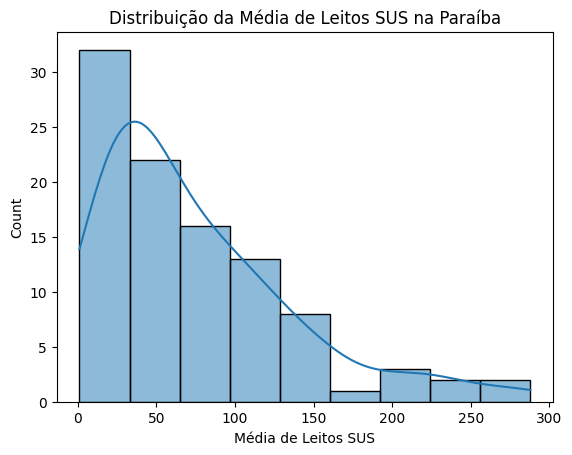

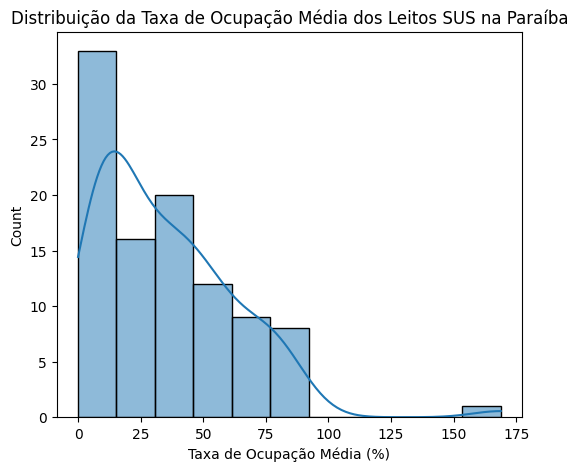

In [9]:
# leitos_sus_mean
medidas_centralidade(df_stats, 'leitos_sus_mean')
medidas_variabilidade(df_stats, 'leitos_sus_mean')
sns.histplot(data=df_stats, x='leitos_sus_mean', kde=True)
plt.title('Distribuição da Média de Leitos SUS na Paraíba')
plt.xlabel('Média de Leitos SUS')

# taxa_ocupacao_mean_pct
print("\n")
medidas_centralidade(df_stats, 'taxa_ocupacao_mean_pct')
medidas_variabilidade(df_stats, 'taxa_ocupacao_mean_pct')
plt.subplots(figsize=(6, 5))
sns.histplot(data=df_stats, x='taxa_ocupacao_mean_pct', kde=True)
plt.title('Distribuição da Taxa de Ocupação Média dos Leitos SUS na Paraíba')
plt.xlabel('Taxa de Ocupação Média (%)')

print('\n------------Top 10 Hospitais Mais Lotados------------')
top_10_lotados = df_stats.nlargest(10, 'taxa_ocupacao_mean_pct').sort_values(by='taxa_ocupacao_mean_pct', ascending=False)
top_10_lotados

### Qual a relação entre os Leitos do SUS e Taxa de Ocupacão?

------------(Leitos SUS com Taxa de Ocupação)------------
Correlação de Pearson: 0.57
Correlação de Spearman: 0.66
Correlação de Kendall: 0.45


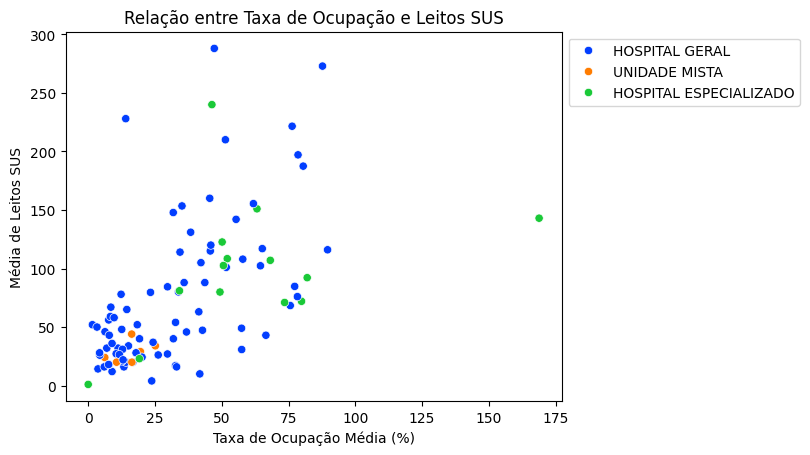

In [10]:
sns.scatterplot(data=df_stats, x='taxa_ocupacao_mean_pct', y='leitos_sus_mean', hue='tipo_unidade', palette='bright')
plt.title('Relação entre Taxa de Ocupação e Leitos SUS')
plt.xlabel('Taxa de Ocupação Média (%)')    
plt.ylabel('Média de Leitos SUS')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

corr_pearson = df_stats['leitos_sus_mean'].corr(df_stats['taxa_ocupacao_mean_pct'], method='pearson')
corr_spearman = df_stats['leitos_sus_mean'].corr(df_stats['taxa_ocupacao_mean_pct'], method='spearman')
corr_kendall = df_stats['leitos_sus_mean'].corr(df_stats['taxa_ocupacao_mean_pct'], method='kendall')

print(f"------------(Leitos SUS com Taxa de Ocupação)------------\nCorrelação de Pearson: {corr_pearson:.2f}\nCorrelação de Spearman: {corr_spearman:.2f}\nCorrelação de Kendall: {corr_kendall:.2f}")

A média de leitos do SUS apresenta uma relação moderada com a taxa de ocupação desses leitos em hospitais da Paraíba, conforme demonstrado pelas correlações de Spearman (0,66) e Kendall (0,45). Isso indica que, em geral, quanto maior for a média de leitos SUS disponibilizados por um hospital, maior tende a ser sua taxa de ocupação.

### Qual a relacão entre a Média de Óbitos e a Taxa de Ocupacao dos Leitos?

------------(Média de Óbitos com Taxa Ocupacão Diária)------------
Correlação de Pearson: 0.09
Correlação de Spearman: 0.12
Correlação de Kendall: 0.09


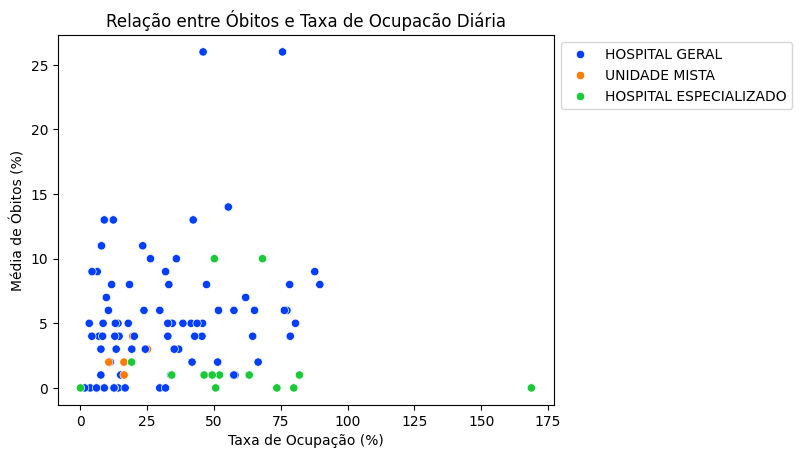

In [11]:
plt.title('Relação entre Óbitos e Taxa de Ocupacão Diária')
plt.ylabel('Média de Óbitos (%)')
plt.xlabel('Taxa de Ocupação (%)')
sns.scatterplot(data=df_stats, x='taxa_ocupacao_mean_pct', y='obitos_mean', hue='tipo_unidade', palette='bright')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Pode ter uma relacao mais forte com tipos de unidades
corr_pearson = df_stats['obitos_mean'].corr(df_stats['taxa_ocupacao_mean_pct'], method='pearson')
corr_spearman = df_stats['obitos_mean'].corr(df_stats['taxa_ocupacao_mean_pct'], method='spearman')
corr_kendall = df_stats['obitos_mean'].corr(df_stats['taxa_ocupacao_mean_pct'], method='kendall')
print(f"------------(Média de Óbitos com Taxa Ocupacão Diária)------------\nCorrelação de Pearson: {corr_pearson:.2f}\nCorrelação de Spearman: {corr_spearman:.2f}\nCorrelação de Kendall: {corr_kendall:.2f}")

### Análise de Regressão Linear
Leitos SUS e Taxa de Ocupacao dos Leitos

Prevendo a taxa de ocupação média para uma média de 260 leitos SUS: [85.66]
b0 (intercept): [15.92]
b1 (coefficient): [0.27]


/home/cecilia_paiva/workspace/ad24_2-proj-superlotacao-em-hospital-da-paraiba/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


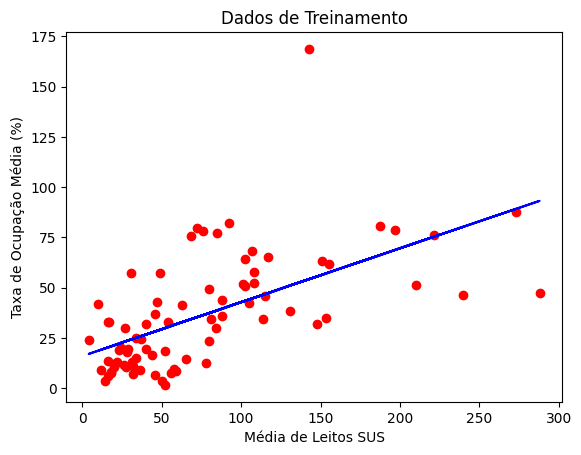

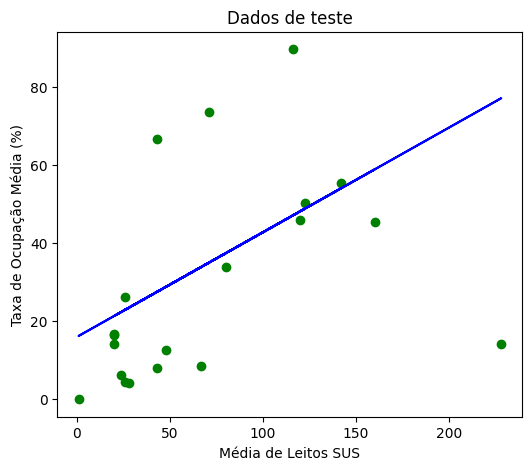

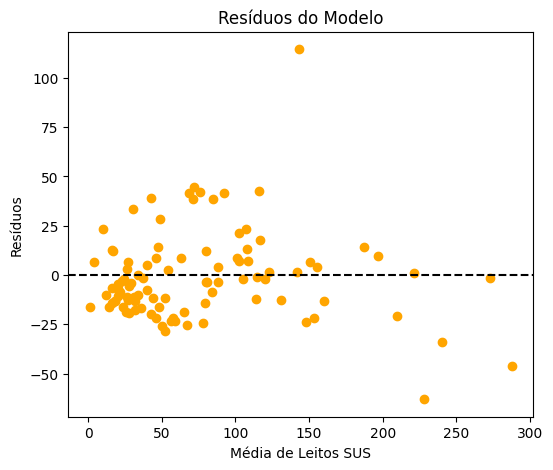

===========Avaliando o Modelo===========
Root Mean Square Error (RMSE): 22.82
Coefficiente of determination (r2): 0.3228


In [12]:
import sklearn.model_selection as ms
import sklearn.linear_model as lm
from sklearn.metrics import mean_squared_error, r2_score

x = df_stats[['leitos_sus_mean']]
y = df_stats[['taxa_ocupacao_mean_pct']]

# Separar os dados em Treino e Teste
x_train, x_test, y_train, y_test = ms.train_test_split(x, y, test_size=0.2, random_state=0)

# Treinando o modelo
regressor = lm.LinearRegression()
regressor.fit(x_train, y_train)

# Previsão
y_pred = regressor.predict(x_test)

# Vizualizar o treino
plt.scatter(x_train, y_train, color='red')
plt.plot(x_train, regressor.predict(x_train), color='blue')
plt.title('Dados de Treinamento')
plt.xlabel('Média de Leitos SUS')
plt.ylabel('Taxa de Ocupação Média (%)')

# Vizualizar o teste
plt.subplots(figsize=(6, 5))
plt.scatter(x_test, y_test, color='green')
plt.plot(x_test, y_pred, color='blue')
plt.title('Dados de teste')
plt.xlabel('Média de Leitos SUS')
plt.ylabel('Taxa de Ocupação Média (%)')

# Valor especificado
valor_especificado = 260
print(f"Prevendo a taxa de ocupação média para uma média de {valor_especificado} leitos SUS: {regressor.predict([[valor_especificado]])[0].round(2)}")
print(f"b0 (intercept): {regressor.intercept_.round(2)}")
print(f"b1 (coefficient): {regressor.coef_[0].round(2)}")

# Erro residual
fitted = regressor.predict(df_stats[['leitos_sus_mean']])	
residuals = y - fitted

plt.subplots(figsize=(6, 5))
plt.scatter(x, residuals, color='orange')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Resíduos do Modelo')
plt.xlabel('Média de Leitos SUS')
plt.ylabel('Resíduos')
plt.show()

# Avaliando o modelo
RMSE = np.sqrt(mean_squared_error(y, fitted))
r2 = r2_score(y, fitted)
print(f'===========Avaliando o Modelo===========\nRoot Mean Square Error (RMSE): {RMSE:.2f}')
print(f'Coefficiente of determination (r2): {r2:.4f}')

Vamos fazer um regressão linear múltipla considerando os tipos de unidades, taxa de óbitos e média de ocupacao diária.

Intercept: [46.966]
Coefficients:
 leitos_sus_mean: -0.300
 obitos_mean: 0.579
 ocupacao_media_diaria: 0.790
 tipo_unidade_HOSPITAL GERAL: -22.373
 tipo_unidade_UNIDADE MISTA: -26.114
===========Avaliando o Modelo===========
Root Mean Square Error (RMSE): 15.28
Coefficiente of determination (r2): 0.6967


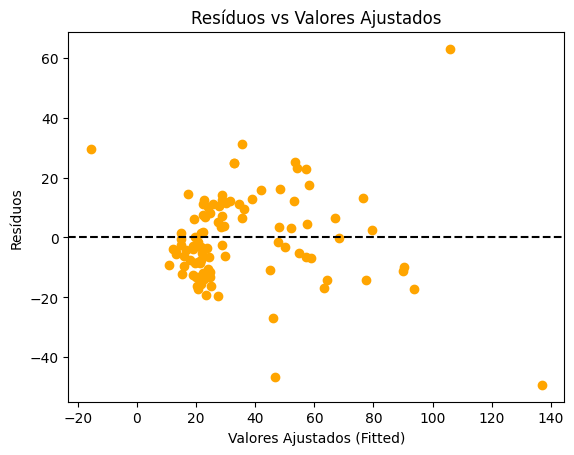

In [13]:
x = df_stats[['leitos_sus_mean', 'tipo_unidade', 'obitos_mean', 'ocupacao_media_diaria']]
y = df_stats[['taxa_ocupacao_mean_pct']]

# Transformar a variável categórica 'tipo_unidade' em variáveis dummy
# Hospital especializado é o dummies de referência
x_dummies = pd.get_dummies(x, drop_first=True)

# Separar os dados em Treino e Teste
x_train, x_test, y_train, y_test = ms.train_test_split(x_dummies, y, test_size=0.2, random_state=0)

# Treinando o modelo
regressor_multiple = lm.LinearRegression()
regressor_multiple.fit(x_train, y_train)

# Coeficientes
print(f'Intercept: {regressor_multiple.intercept_.round(3)}')
print('Coefficients:')
for name, coef in zip(x_dummies.columns, regressor_multiple.coef_.flatten()):
    print(f' {name}: {coef:.3f}')

# Previsão
y_pred = regressor_multiple.predict(x_test)

# Avaliando o modelo
fitted = regressor_multiple.predict(x_dummies)
RMSE = np.sqrt(mean_squared_error(y, fitted))
r2 = r2_score(y, fitted)
print(f'===========Avaliando o Modelo===========\nRoot Mean Square Error (RMSE): {RMSE:.2f}')
print(f'Coefficiente of determination (r2): {r2:.4f}')

# Calcular os resíduos
residuals = y - fitted

# Gráfico de Resíduos vs Valores Ajustados
plt.scatter(fitted, residuals, color='orange')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Resíduos vs Valores Ajustados')
plt.xlabel('Valores Ajustados (Fitted)')
plt.ylabel('Resíduos')
plt.show()

### Regressão Logística

Sem 'MUNICIPIO' como variável preditora.

In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

df_combined = sih_pb_2024.merge(df_ocupacao_diaria, on=['id_cnes', 'mes_ano', 'data'], how='left')
df_combined = df_combined.dropna(subset=['taxa_ocupacao_diaria_pct'])

x_predictors = df_combined[['DS_TIPO_UNIDADE', 'IDADE', 'taxa_ocupacao_diaria_pct']]
y_outcome = df_combined['obito']

# Dummies
x_pred_dummies = pd.get_dummies(x_predictors, columns=['DS_TIPO_UNIDADE'], drop_first=True)

# Escalar os dados
scaler = StandardScaler()
x_pred_scaled = scaler.fit_transform(x_pred_dummies)

# Separar os dados em Treino e Teste
x_train, x_test, y_train, y_test = ms.train_test_split(x_pred_scaled, y_outcome, test_size=0.2, random_state=0)

# SMOTE balanceia as classes, aumentando a quantidade de amostras da classe minoritária
smote = SMOTE(random_state=0)
x_train_balanced, y_train_balanced = smote.fit_resample(x_train, y_train)

# Treinando o modelo
logistic_regressor = LogisticRegression(class_weight='balanced', max_iter=1000)
logistic_regressor.fit(x_train_balanced, y_train_balanced)

# Previsao
y_pred = logistic_regressor.predict(x_test)
y_pred_proba = logistic_regressor.predict_proba(x_test)

# Avaliando o modelo
print(y_outcome.value_counts())
print(f"Matrix de confusão:\n{confusion_matrix(y_test, y_pred)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

# Para ver os coeficientes de cada variável
coef_df = pd.DataFrame({
    'Variável': x_pred_dummies.columns,
    'Coeficiente': logistic_regressor.coef_[0].round(3)
})
coef_df = coef_df.sort_values(by='Coeficiente', ascending=False)
print("Intercept: ", logistic_regressor.intercept_.round(3))
coef_df

obito
0    216432
1     10628
Name: count, dtype: int64
Matrix de confusão:
[[30294 13048]
 [  447  1623]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.70      0.82     43342
           1       0.11      0.78      0.19      2070

    accuracy                           0.70     45412
   macro avg       0.55      0.74      0.51     45412
weighted avg       0.95      0.70      0.79     45412

Intercept:  [-0.638]


,Variável,Coeficiente
0,IDADE,1.151
2,DS_TIPO_UNIDADE_HOSPITAL GERAL,0.094
1,taxa_ocupacao_diaria_pct,0.064
3,DS_TIPO_UNIDADE_UNIDADE MISTA,-0.072


Com 'MUNICIPIO' como variável preditora.

In [15]:
x_predictors = df_combined[['MUNICIPIO', 'DS_TIPO_UNIDADE', 'IDADE', 'taxa_ocupacao_diaria_pct']]
y_outcome = df_combined['obito']

# Dummies
x_pred_dummies = pd.get_dummies(x_predictors, columns=['MUNICIPIO', 'DS_TIPO_UNIDADE'], drop_first=True)

# Separar os dados em Treino e Teste
x_train, x_test, y_train, y_test = ms.train_test_split(x_pred_dummies, y_outcome, test_size=0.2, random_state=0)

# Escalar os dados
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# SMOTE balanceia as classes, aumentando a quantidade de amostras da classe minoritária
smote = SMOTE(random_state=0)
x_train_balanced, y_train_balanced = smote.fit_resample(x_train, y_train)

# Treinando o modelo
logistic_regressor = LogisticRegression(class_weight='balanced', max_iter=2000)
logistic_regressor.fit(x_train_balanced, y_train_balanced)

# Previsao
y_pred = logistic_regressor.predict(x_test)
y_pred_proba = logistic_regressor.predict_proba(x_test)

# Avaliando o modelo
print(y_outcome.value_counts())
print(f"Matrix de confusão:\n{confusion_matrix(y_test, y_pred)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

obito
0    216432
1     10628
Name: count, dtype: int64
Matrix de confusão:
[[36203  7139]
 [ 1023  1047]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.84      0.90     43342
           1       0.13      0.51      0.20      2070

    accuracy                           0.82     45412
   macro avg       0.55      0.67      0.55     45412
weighted avg       0.93      0.82      0.87     45412



In [16]:
# Para ver os coeficientes de cada variável
coef_df = pd.DataFrame({
    'Variável': x_pred_dummies.columns,
    'Coeficiente': logistic_regressor.coef_[0].round(3)
})
coef_df = coef_df.sort_values(by='Coeficiente', ascending=False)
print("Intercept: ", logistic_regressor.intercept_.round(3))
coef_df

Intercept:  [-12.304]


,Variável,Coeficiente
29,MUNICIPIO_JOAO PESSOA,8.348
18,MUNICIPIO_CAMPINA GRANDE,8.206
24,MUNICIPIO_GUARABIRA,7.789
52,MUNICIPIO_SAPE,7.663
40,MUNICIPIO_PIANCO,7.649
...,...,...
10,MUNICIPIO_BOM SUCESSO,-0.082
28,MUNICIPIO_JERICO,-0.183
53,MUNICIPIO_SERIDO,-0.239
11,MUNICIPIO_BONITO DE SANTA FE,-0.319


### Conclusões

- A superlotação de hospitais na Paraíba atinge principalmente as regiões metropolitanas, onde a demanda é maior e a oferta de leitos SUS também é maior;

- Existe um possível déficit na distribuição dos hospitais especializados que têm leitos SUS no Estado, os quais têm uma demanda considerável;

- A taxa de óbito influencia na taxa de ocupação, provavelmente um hospital que lida com casos de alta gravidade, obtém uma maior taxa de óbito e também uma alta taxa de ocupação;

- Os municípios que se destacaram nas análises, são de regiões metropolitanas ou arredores, os quais muitas outras cidades dependem de seus serviços.

- No geral, poucos hospitais do Estado enfrentaram uma superlotação, sendo esses da categória hospital especializado e geral localizados nos grandes centros urbanos.